# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Read-In

In [3]:
df = pd.read_csv("./DATA/data_banknote_authentication.csv")
df.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# ML Preprocessing

### Feature | Target Split

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

### Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Model Building

### Imports

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### Parameter Grid

In [7]:
n_estimators = [64, 100, 128, 200]
max_features = [2, 3, 4]
bootstrap=[True,False]
oob_score = [True, False]
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features, 
             'bootstrap':bootstrap, 
             'oob_score':oob_score}

### Setup and Training of Model 

In [11]:
rfc = RandomForestClassifier(oob_score=True, bootstrap=True)

In [12]:
grid = GridSearchCV(rfc, param_grid)

In [13]:
grid.fit(X_train, y_train)

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 448, in fit
    raise ValueError

GridSearchCV(estimator=RandomForestClassifier(oob_score=True),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200],
                         'oob_score': [True, False]})

### Retraining Model based on Best Parameters as found by Grid Search

In [14]:
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 64, 'oob_score': False}

In [15]:
rfc = RandomForestClassifier(max_features=2, 
                             n_estimators=64,
                             oob_score=False, 
                             bootstrap=True)

In [16]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=2, n_estimators=64)

# Prediction and Evaluations

In [18]:
preds = rfc.predict(X_test)

### Metrics

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [20]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       124
           1       0.99      1.00      0.99        82

    accuracy                           1.00       206
   macro avg       0.99      1.00      0.99       206
weighted avg       1.00      1.00      1.00       206



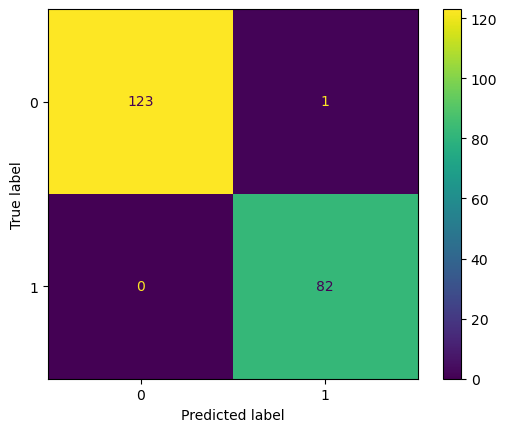

In [21]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

## Saving model as a .pkl file

In [22]:
import pickle

with open('./Models/banknote_classifer.pkl', 'wb') as file:
    pickle.dump(rfc, file)

## Model Explainability using LIME

Intercept 0.42141869415851346
Prediction_local [0.43383813]
Right: 0.0


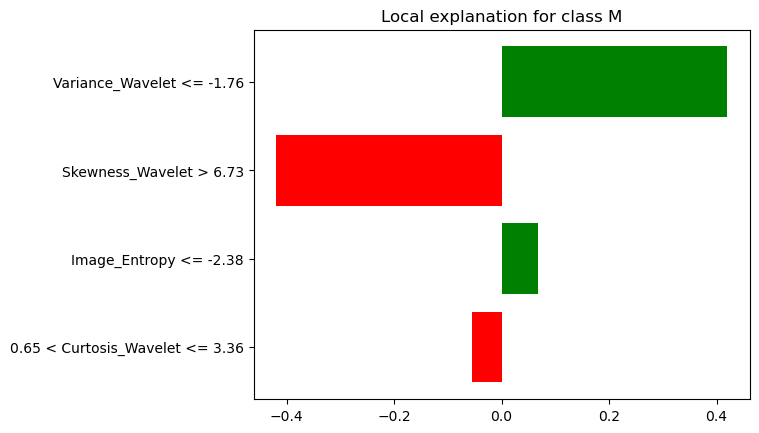

In [25]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Fix 1: Set correct class names (binary example: 0 = No, 1 = Yes)
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=['R', 'M'],  # ← use actual class names
    mode='classification',
    verbose=True
)

def lime_predict_fn(x):
    df = pd.DataFrame(x, columns=X.columns)
    return rfc.predict_proba(df)

explanation = explainer.explain_instance(
    X_test.iloc[0].values,
    lime_predict_fn
)

label_to_plot = explanation.available_labels()[0]  

fig = explanation.as_pyplot_figure(label=label_to_plot)
fig.patch.set_facecolor('white')  # white background for dark notebooks
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.show()
